# Neighbs

In [1]:
from ipynb.fs.full.koselleck import *

In [2]:
def do_nbr_word(dfgrp,max_rank=NBR_MAX_RANK,num_proc=1,progress=True):
    words_with_data=set(dfgrp.columns)
    o=[]
    for (word,period,run),wprdf in dfgrp.groupby(['word_','period_','run_']):
        row=wprdf.iloc[0].dropna().sort_values()
        to_drop={word} | (set(row.index) - words_with_data)
        row=row.drop(to_drop)
        o+=[
            {
                'word':word,
                'period':period,
                'run':run,
                'neighbor':nb,
                'cdist':val,
                'rank':i+1
            } for i,(nb,val) in enumerate(row.items())
            if i<max_rank
        ]
    dfprd=pd.DataFrame(o)
    gby=['word','period','neighbor']
    dfprdg=dfprd.groupby(gby)
    dfprd=dfprd.reset_index().set_index(gby)
    dfprd['count']=dfprdg.size()
    dfprd['score']=[(c - (cd/10)) for c,cd in zip(dfprd['count'], dfprd['cdist'])]
    odf=dfprd.groupby(gby).agg(dict(
        count=np.median,
        score=np.mean,
#         run=np.max,
        cdist=np.mean
    ))
    odf['rank']=odf['score'].rank(ascending=False,method='min').apply(int)
    odf=odf.drop('score',1).sort_values('rank')
#     odf=odf.rename({'run':'num_runs'},axis=1)
    if max_rank: odf=odf[odf['rank']<=max_rank]
    return odf.reset_index().drop(['word','period'],axis=1)

def nbr_word(word,period_or_periods=None,run_or_runs=None,num_runs=10,num_proc=1,progress=True,
             max_rank=NBR_MAX_RANK,cache=True,cache_only=False,force=False,pmap_use_cache=False,
             only_valid_words=False):
    if progress: print(f'Running nbr_word({word})')
    qstr=f'{word},max_rank={max_rank},ymin={YMIN},ymax={YMAX},ybin={YEARBIN}'
    if cache and not force:
        with get_veclib('nbr') as vl:
            if qstr in vl:
                if progress: print(f'Finished running nbr_word({word})')
                if not cache_only:
                    dfnbr=vl[qstr]
                    if only_valid_words:
                        valid_words=set(get_valid_words()) & set(dfnbr.index.get_level_values('neighbor'))
                        dfnbr=dfnbr.loc[:,:,valid_words]
                    return dfnbr if not cache_only else pd.DataFrame()
    
    dfc = cdist_word(word,period_or_periods,num_proc=num_proc,progress=progress)
    if not len(dfc): return pd.DataFrame()
    odf=pmap_groups(
        do_nbr_word,
        dfc.rename_axis(['word_','period_','run_']).groupby(['word_','period_']),
        kwargs=dict(max_rank=max_rank,num_proc=1,progress=False),
        num_proc=num_proc,
        progress=progress,
        use_cache=pmap_use_cache
    )
    if not len(odf): return pd.DataFrame()
    odf=odf.rename_axis(['word','period']).reset_index().set_index(['word','period','neighbor'])
    if cache:
        with get_veclib('nbr',autocommit=True) as vl:
            vl[qstr]=odf

    if not cache_only and only_valid_words:
        valid_words=set(get_valid_words()) & set(odf.index.get_level_values('neighbor'))
        odf=odf.loc[:,:,valid_words]
    if progress: print(f'Finished running nbr_word({word})')
    return odf if not cache_only else pd.DataFrame()

In [3]:
dfnbr=nbr_word('price',force=False,progress=1,num_proc=1,only_valid_words=True).query('neighbor=="gd"')
dfnbr

[Koselleck] (08:08:26) Running nbr_word(price) (+0.1s)
[Koselleck] (08:08:27) Finished running nbr_word(price) (+0.0s)


,,,count,cdist,rank
word,period,neighbor,,,


In [4]:
# dfnbr.groupby('period').size()

In [5]:
nbr_word('despotism',num_proc=4,cache=True)

[Koselleck] (08:08:27) Running nbr_word(despotism) (+0.5s)
[Koselleck] (08:08:27) Finished running nbr_word(despotism) (+0.0s)


count     cdist  rank
word      period    neighbor                          
despotism 1765-1770 regal            8  0.769257     1
                    tyranny          8  0.799319     2
                    despotic         8  0.827274     3
                    tyrannical       8  0.833121     4
                    slavery          8  0.868571     5
...                                ...       ...   ...
          1885-1890 phase            1  1.193029   996
                    irish            1  1.193325   997
                    calculation      1  1.194214   998
                    alexandria       1  1.194275   999
                    utmost           1  1.194479  1000

[25000 rows x 3 columns]

In [6]:
def _nbr_(objd): return nbr_word(**objd)

def nbr(word_or_words,period_or_periods=None,run_or_runs=None,max_rank=NBR_MAX_RANK,num_runs=10,
        num_proc=1,force=False,progress=True,cache_only=False,cache=True,use_threads=False,
        pmap_use_cache=False,only_valid_words=False):
    index_cols=['word','neighbor','period','run']
    words=tokenize_fast(word_or_words) if type(word_or_words)==str else list(word_or_words)
    objs=[
        dict(
            word=word,
            period_or_periods=period_or_periods,
            run_or_runs=run_or_runs,
            num_runs=num_runs,
            num_proc=1 if len(words)>1 else num_proc,
            progress=False if len(words)>1 else progress,
            max_rank=NBR_MAX_RANK,
            cache=cache,
            cache_only=cache_only,
            force=force,
            pmap_use_cache=pmap_use_cache,
            only_valid_words=only_valid_words
        ) for word in words
    ]
    o=pmap(
        _nbr_,
        objs,
        num_proc=num_proc if len(words)>1 else 1,
        progress=progress if len(words)>1 else False,
        desc='Gathering word neighborhoods',
        use_threads=use_threads
    )
    return pd.concat(o) if len(o) else pd.DataFrame()


In [7]:
nbr(['virtues','representations','virtue','territories','kingdoms'],num_proc=4)

Gathering word neighborhoods [x4]: 100%|██████████| 5/5 [00:00<00:00, 22.66it/s]


count     cdist  rank
word     period    neighbor                        
virtues  1720-1725 wisdom        10  0.923790     1
                   qualities     10  0.935153     2
                   esteem        10  0.959071     3
                   piety         10  0.969421     4
                   glorious      10  1.013632     5
...                             ...       ...   ...
kingdoms 1895-1900 arch           1  1.244768   996
                   humanity       1  1.244944   997
                   gorge          1  1.244982   998
                   criminals      1  1.245101   999
                   duel           1  1.245274  1000

[180000 rows x 3 columns]

## Speed tests

Winner was:

```python
%%timeit
nbr(random.sample(get_valid_words(),10),num_proc=6,cache_only=True)
```

with ~2.5s/word on average.

In [8]:
# @interact
# def spw(spw=2.5,numword=len(get_valid_words())):
#     print(f'ETA: {round( (spw * numword) / 60 / 60,1)} hours')

In [9]:
# %%timeit
# nbr(random.sample(get_valid_words(),10),num_proc=6,cache_only=True)

In [10]:
# %%timeit
# nbr(random.sample(get_valid_words(),10),num_proc=6,cache_only=True,pmap_use_cache=True)

In [11]:
# %%timeit
# nbr(random.sample(get_valid_words(),10),num_proc=4,cache_only=True)

In [12]:
# %%timeit
# nbr(random.sample(get_valid_words(),10),num_proc=1,cache_only=True)

In [13]:
# %%timeit
# nbr(random.sample(get_valid_words(),10),num_proc=4,cache_only=True,use_threads=True)

In [14]:
# %%timeit
# nbr(random.sample(get_valid_words(),10),num_proc=8,cache_only=True,use_threads=True)

## Importing older data

In [15]:
def load_older_data_neighbs(ifn=FN_ALL_NEIGHBS):
    df=read_df(ifn)
    df=df.query(f'"{YMIN}"<=period<"{YMAX}"')
    df['cdist']=1-df['csim']
    df['num_runs']=10
    df['count']=df['count'].apply(int)
    odf=df.set_index(['word','neighbor','period'])[['count','num_runs','cdist','rank']]
    return odf

In [16]:
# dfold=load_older_data_neighbs()
# dfold

In [17]:
def import_older_data_neighbs(df):
    with get_veclib('nbr',autocommit=False) as vl:
        for i,(word,wdf) in enumerate(tqdm(df.groupby('word'))):
            wqstr=f'{word},ymin={YMIN},ymax={YMAX},ybin={YEARBIN}'
            if not wqstr in vl:
                vl[wqstr]=wdf
            if i and not i%100: vl.commit()
        vl.commit()

In [18]:
# import_older_data_neighbs(dfold)

## Reorganizing data for different period lengths

In [19]:
w='communication'
year_min=1720
year_max=1900
ybin=20
max_rank=10

In [21]:
# dfres

In [29]:
# dfres=nbr(w)
# wdf=dfres.loc[w].reset_index()
# wdf=wdf.query(f'period>="{year_min}"')
# wdf=wdf.query(f'period<"{year_max}"')
# wdf

In [30]:
# wdf['period_orig']=wdf['period']
# wdf['period']=[periodize(int(y.split('-')[0]),ybin) for y in wdf.period_orig]
# wdf

In [31]:
# wdf2 = wdf.groupby(['period','neighbor']).agg(dict(count=sum, cdist=np.mean, rank=np.median))
# wdf2

In [32]:
# wdf2.sort_values('count')

In [33]:
# wdf2['score']=[(c - (cd/10)) for c,cd in zip(wdf2['count'], wdf2['cdist'])]
# wdf2['rank_avg']=wdf2['rank']
# wdf2

In [27]:
# wdf3=pd.concat(dfg.assign(rank=dfg.score.rank(ascending=False)) for i,dfg in wdf2.groupby('period'))
# wdf3

In [28]:
# wdf3.query(f'rank<={max_rank}').sort_values(['period','rank']).head(25)

NameError: name 'wdf3' is not defined

In [34]:
# wdf=wdf[wdf['rank']<=max_rank]


In [35]:
# stop

## Regenerating data

In [36]:
words=get_valid_words()
random.shuffle(words)
len(words),words[:10]

(15662,
 ['bright',
  'legible',
  'extremity',
  'scholastic',
  'tome',
  'commendable',
  'salary',
  'mutiny',
  'highlanders',
  'heraldry'])

In [37]:
# nbr(words,num_proc=4,cache_only=True,pmap_use_cache=False)

In [38]:
## Plot neighbors

In [1]:
def plot_nbrs(
        word='station',
        vnum='v18-newnbr-20y-5-v-20',
        min_periods=2,
        max_rank=10,
        max_rank1=10,
        width=8,
        height=5,
        save=False,
        showdata=False,
        year_min=YMIN,
        year_max=YMAX,
        ybin=20,
        num_proc=2,
        progress=False,
        returndata=True):
    w=word
    dfres=nbr(w,num_proc=num_proc,progress=progress,only_valid_words=True)
    
#     if w in set(dfres.index):
    if len(dfres):
        wdf=dfres.loc[w].reset_index()
        wdf=wdf.query(f'period>="{year_min}"')
        wdf=wdf.query(f'period<"{year_max}"')
        
        wdf['period_orig']=wdf['period']
        wdf['period']=[periodize(int(y.split('-')[0]),ybin) for y in wdf.period_orig]
        
        wdf = wdf.groupby(['period','neighbor']).agg(dict(count=sum, cdist=np.mean, rank=np.median))
        wdf['score']=[(c - (cd/10)) for c,cd in zip(wdf['count'], wdf['cdist'])]
        wdf['rank_avg']=wdf['rank']
        wdf['rank']=wdf.score.rank()
        wdf=pd.concat(dfg.assign(rank=dfg.score.rank(ascending=False)) for i,dfg in wdf.groupby('period'))
        wdf=wdf.reset_index()
        
        words_ever_high=set(wdf[wdf['rank_avg']<=max_rank1].neighbor)
        figdf=wdf
        figdf=figdf[figdf.neighbor.isin(words_ever_high)].groupby(
            ['period','neighbor']).mean().reset_index()
        wdfp=figdf.pivot('neighbor','period','score')
        figdf=wdfp.reset_index().melt(id_vars=['neighbor'],value_name='score')
        
        figdf=figdf.groupby('neighbor').filter(lambda gdf: gdf.dropna().period.nunique()>=min_periods)
        
        figdf=pd.concat(
            grp.assign(rank=(grp['score']).rank(method='first'))
            for i,grp in figdf.groupby('period')
        )
        figdf=figdf[figdf['rank']<=max_rank]
        figdf=figdf.sort_values(['period','rank'])
        if showdata: display(figdf)
        if returndata: return figdf
                        
        # start fig
        fig=start_fig(
            figdf,
            x='period',
            y='rank',
            label='neighbor',
#             group='neighbor',
#             color='neighbor',
#             fill='conc',
            figure_size=(width,height)
        ) + p9.geom_line(p9.aes(group='neighbor'),size=0.5) + p9.scale_y_reverse()
        
        first_appearances=figdf.sort_values('period').drop_duplicates('neighbor')
        other_appearances=figdf.loc[set(figdf.index) - set(first_appearances.index)]
        
        fig+=p9.geom_label(size=6.5,data=other_appearances)
        fig+=p9.geom_label(size=6.5,fill='#BBBBBB',fontweight='bold',data=first_appearances)
        
        fig+=p9.scale_fill_gradient(low='white',high='#999999')
#         fig+=p9.scale_color_gradient(low='white',high='#999999')
        fig+=p9.labs(
            title=f'Most similar words to "{w}", {year_min}-{year_max}',
            x='Date of semantic model',
            y=f'Proximity to "{w}" →',
            fill='Concreteness'
        )
        if save:
            ofn=f'fig.changing_simple.{w}.{vnum}.png'
            fig.save(f'figures/{ofn}')
            fig.save(f'/home/ryan/Markdown/Drafts/TheGreatAbstraction/figures/{ofn}')
#         display(fig)
#         return figdf
        return fig
    else:
        return f'!! {w} not in data'
    
    
# res=interact_manual(plot_nbrs)
# # res()

NameError: name 'YMIN' is not defined

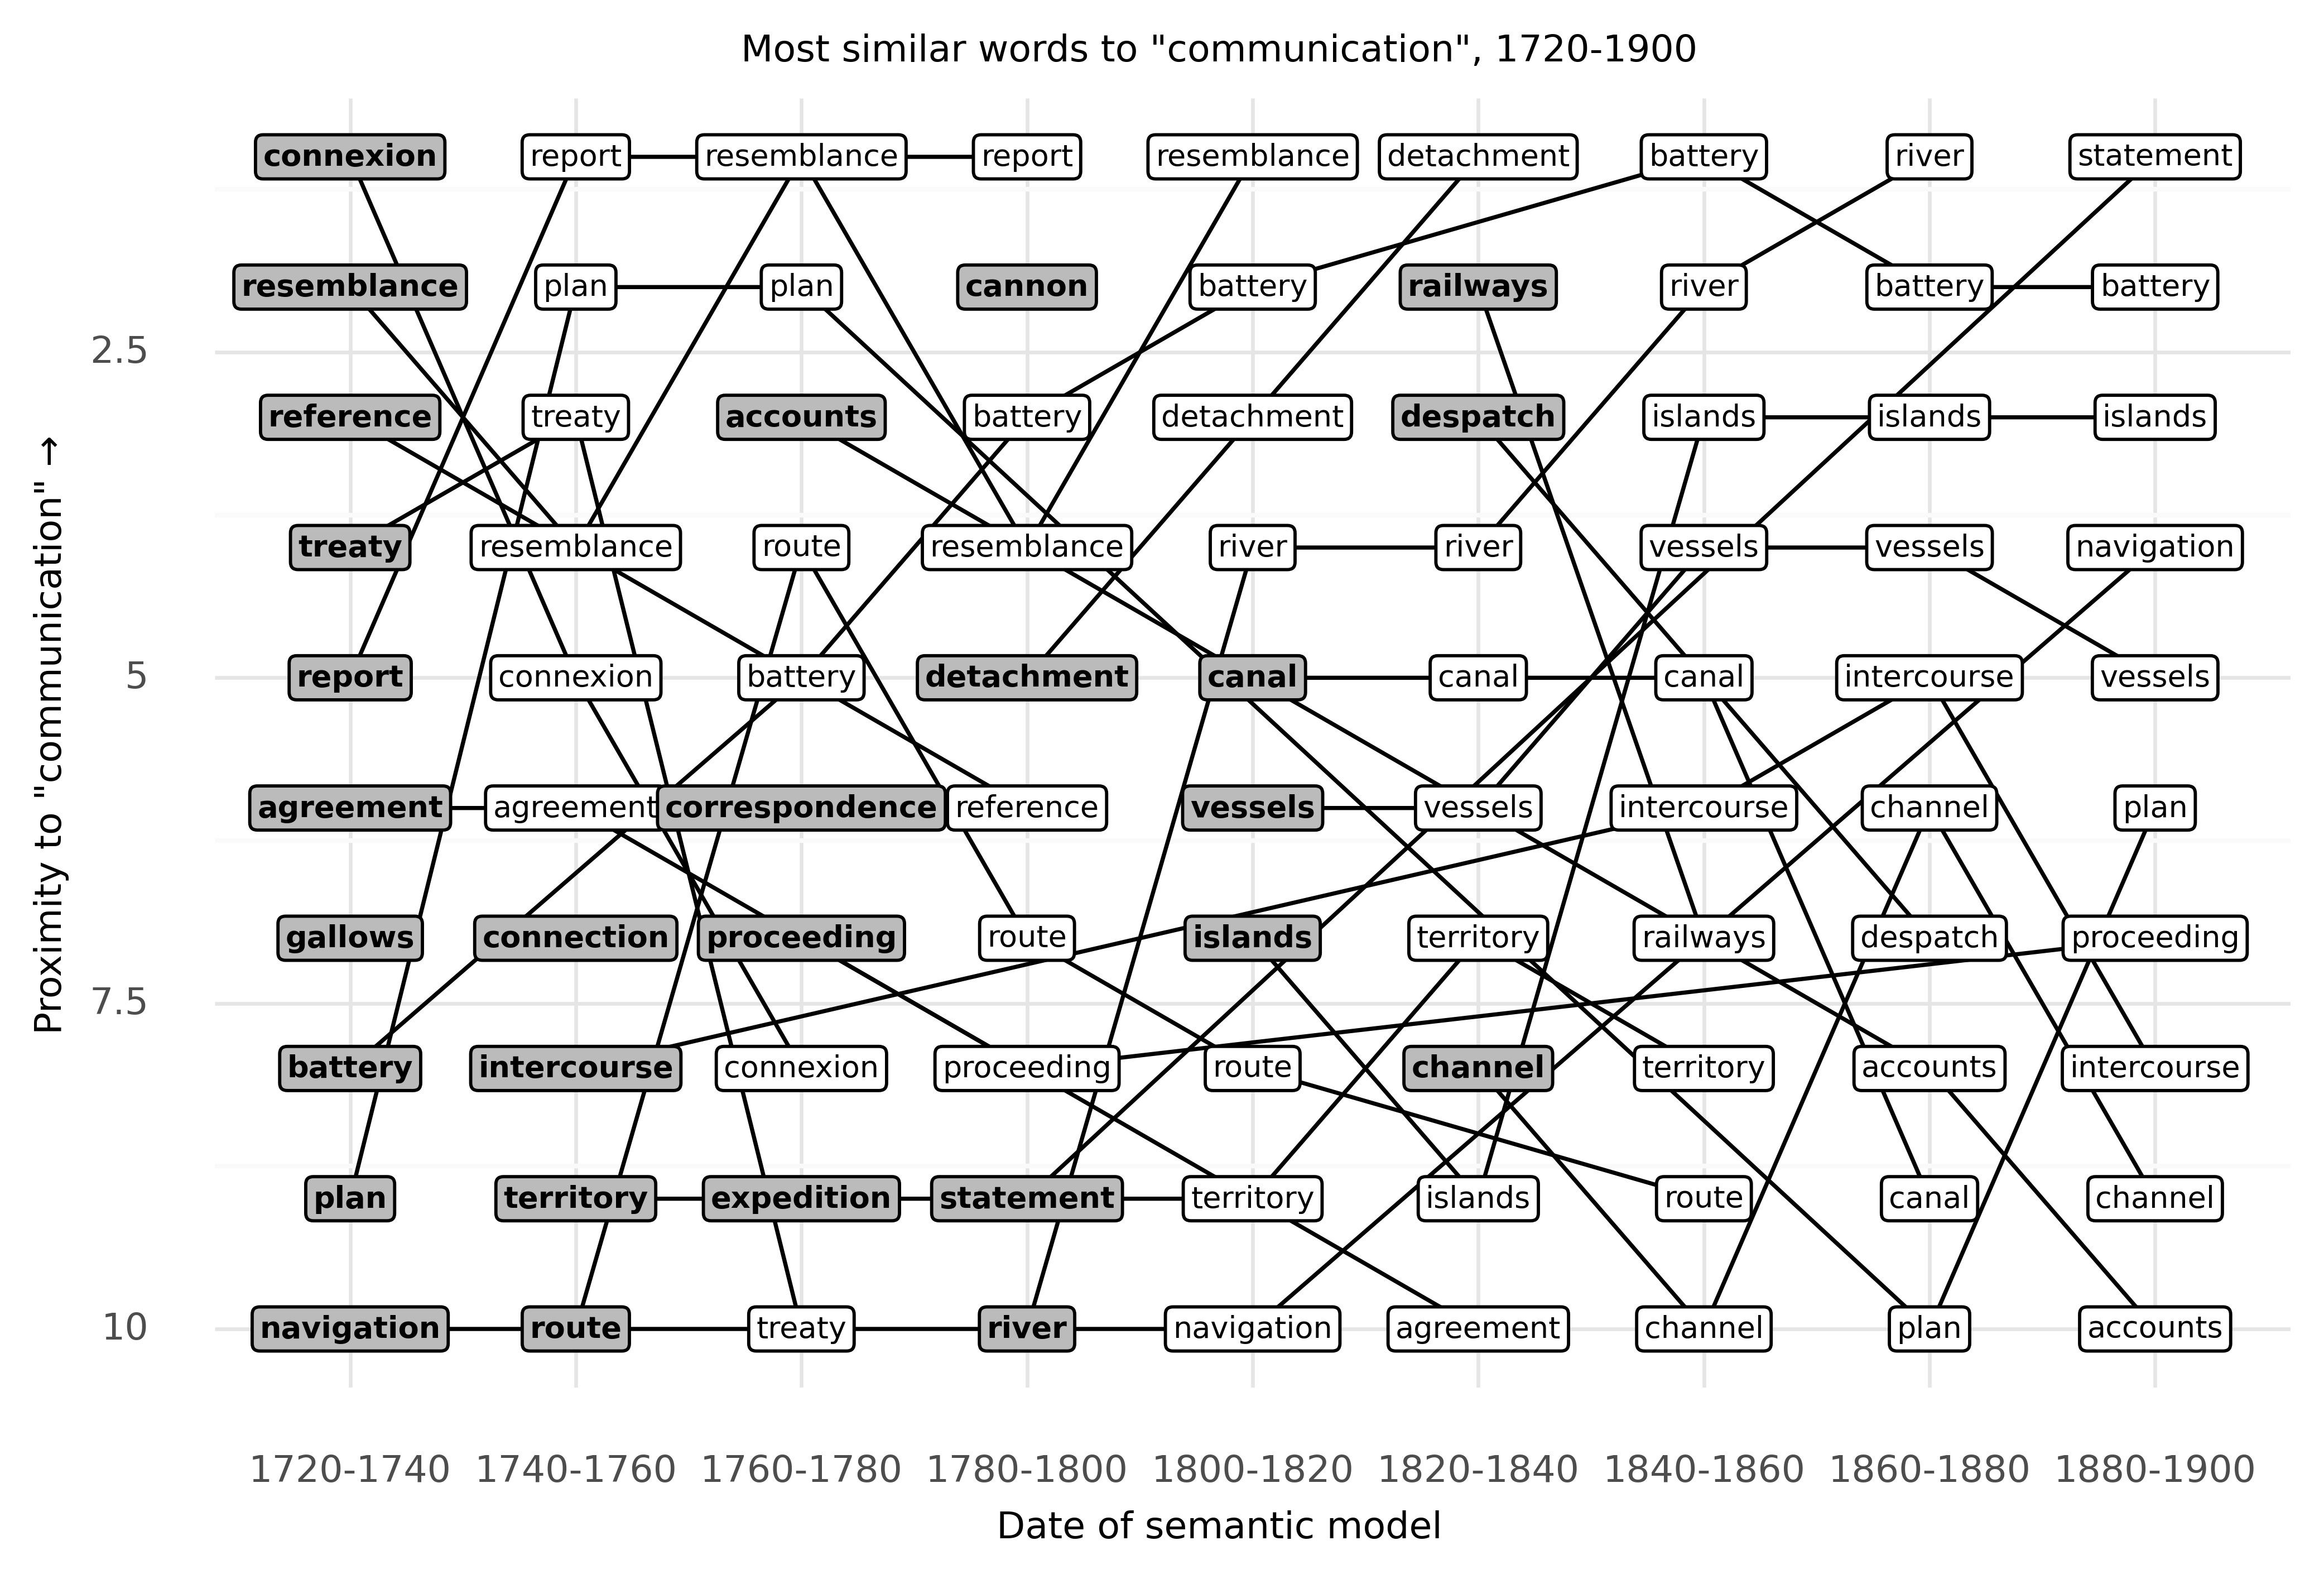

<ggplot: (8793339483541)>

In [94]:
plot_nbrs('communication',showdata=False,min_periods=1,max_rank=10)